## COMPAS Analysis using Aequitas

In 2016, ProPublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based off of [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset, found in the ProPublica repo, we demostrate the use of the Aequitas bias reporting tool. 


Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the widest used risk assessment tools, algorithms which are used in the criminal justice system to guide decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

### Exploratory Analysis

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.aequitas.group import Group
from src.aequitas.bias import Bias
from src.aequitas.fairness import Fairness
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [3]:
# df = pd.read_csv('../data/cox-parsed.csv')
df_g = pd.read_csv('../data/compas-scores-two-years.csv')
df_g.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


COMPAS provides three scores meant to measure likelihood of recidivism, likelihood of violent recidivism and likelihood of failing to appear at a court date.

The field `decile_score` is the predicted risk decile for recidivism, with 1 being very low and 10 high. `score_text` represents that category of predicted risk, which groups the predicted decile into `Low`, `Medium`, and `High`. Let's take a look at these distributions.

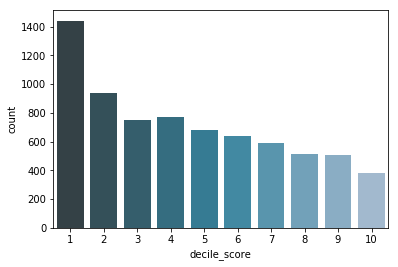

In [3]:
sns.countplot(x='decile_score', data=df_g,palette="PuBuGn_d")

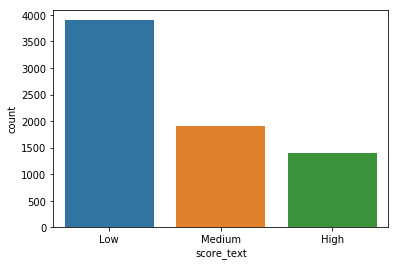

In [4]:
cat_type = CategoricalDtype(categories=["Low", "Medium", "High"], ordered=True)
df_g.score_text = df_g.score_text.astype(cat_type)
sns.countplot(x='score_text', data=df_g)

We see that most people are predcited into the `Low` category (and thus the low deciles), with much fewer in the `Medium`/`High` range. We are interested in how `race` affects these distributions. First, we take a look at the overall distribution of race in the sample.

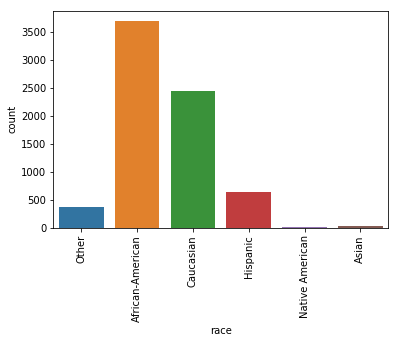

In [5]:
g = sns.countplot(x="race", data=df_g).set_xticklabels(labels=df_g.race.unique(),rotation=90)

We see that `African-American` is the largest category, followed by `Caucasian`. For ease of visualization, we focus on these 2 races.

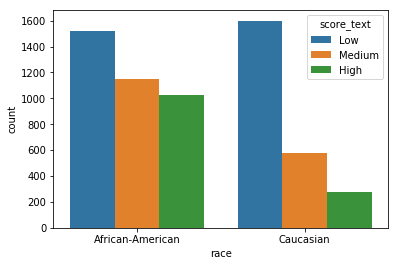

In [6]:
g = sns.countplot(x="race", hue="score_text", data=df_g[df_g.race.isin(['African-American', 'Caucasian'])])

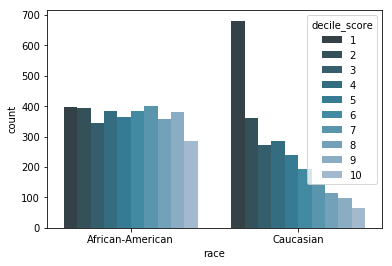

In [7]:
g = sns.countplot(x="race", hue="decile_score", data=df_g[df_g.race.isin(['African-American', 'Caucasian'])], palette="PuBuGn_d")

We see a huge difference in these distributions, with white people significantly more likely to be predicted into the first decile (indicating a very low risk) than black people. This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `two_year_recid` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"

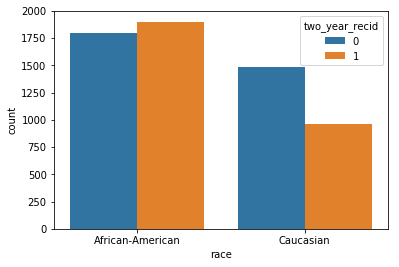

In [8]:
g = sns.countplot(x="race", hue="two_year_recid", data=df_g[df_g.race.isin(['African-American', 'Caucasian'])])

### Aequitas example

The above graph shows the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39). The graphs above that show white defendants are more often predicted to be low risk than high risk, while black defendants are more-or-less evenly distributed across the decile scores.

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that we have multiple ways to measure bias adds complexity to the decisionmaking process. With Aequitas, we provide a tool that automates the reporting of various fairnes metrics to aid in this process.

Applying Aequitas is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness






#### Group()
Now, using the Aequitas bias detection tool, we calculate precise bias and disparity metrics for this dataset. 
First, we modify the dataframe to be compatible with the tool. 

Aequitas expects a dataframe expects predefined columns `entity_id`, `score`, and `label_value` and treats all other columns (besides `model_id` and `as_of_date`) as group attributes against which to test for disparities. In this cases we include `race`, `sex` and `age_cat`. 


In [4]:
df = pd.read_csv('../data/compas-scores-two-years.csv')
df = df[['id', 'decile_score', 'score_text', 'two_year_recid', 'race', 'sex', 'age_cat']]
df = df.sort_values('decile_score', ascending=False)
# df['model_id'] = 1
df['score'] = df.decile_score/10
df['rank_abs'] = range(1, len(df)+1)
# rename for tool
df = df.rename(columns={'id':'entity_id', 
                        'two_year_recid':'label_value'})

rank_cutoff = min(df[df.score_text=="Low"].rank_abs)-1

In [5]:
df.groupby('score_text').decile_score.describe()

,count,mean,std,min,25%,50%,75%,max
score_text,,,,,,,,
High,1403.0,8.908054,0.793671,8.0,8.0,9.0,10.0,10.0
Low,3897.0,2.216833,1.141860,1.0,1.0,2.0,3.0,4.0
Medium,1914.0,5.953501,0.814422,5.0,5.0,6.0,7.0,7.0


We now use the `get_crosstabs` function to find the bias metrics across groups of interest, which here we are considering to be race, gender, and age.

In [7]:
df = df[[x for x in df.columns if x not in ['score_text', 'decile_score']]]
g = Group()
ct, p = g.get_crosstabs(df, {'rank_abs':[rank_cutoff]}, model_id=1)

Feature Columns (Groups): ['race' 'sex' 'age_cat']
COUNTS::: race
African-American    3696
Asian                 32
Caucasian           2454
Hispanic             637
Native American       18
Other                377
Name: entity_id, dtype: int64
COUNTS::: sex
Female    1395
Male      5819
Name: entity_id, dtype: int64
COUNTS::: age_cat
25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: entity_id, dtype: int64


In [14]:
df[['entity_id', 'score', 'label_value','race', 'sex', 'age_cat']].to_csv('../data/compas_for_aequitas.csv', index=False)

In [11]:
ct[['group_variable', 'group_value', 'FPR', 'FNR', 'TPR', 'TNR']]

,group_variable,group_value,FPR,FNR,TPR,TNR
0,race,African-American,0.448468,0.279853,0.720147,0.551532
1,race,Asian,0.086957,0.333333,0.666667,0.913043
2,race,Caucasian,0.234543,0.477226,0.522774,0.765457
3,race,Hispanic,0.214815,0.556034,0.443966,0.785185
4,race,Native American,0.375000,0.100000,0.900000,0.625000
5,race,Other,0.147541,0.676692,0.323308,0.852459
6,sex,Female,0.321070,0.391566,0.608434,0.678930
7,sex,Male,0.324201,0.370868,0.629132,0.675799
8,age_cat,25 - 45,0.333784,0.373743,0.626257,0.666216
9,age_cat,Greater than 45,0.167904,0.572289,0.427711,0.832096


We see that African-Americans have a false positive rate of 45%, while Caucasians have a false positive rate of only 23%. This means that black people are far more likely to be falsely labeled as high-risk than white people. Additionally, we see that those in the "Less than 25" category have a 54% fpr, which is very high.

#### Bias()
We calculate disparities as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use `get_disparity_predefined_groups` which allows us to choose base groups that clarify the output for the practitioner. Aequitas `Bias()` class includes two additional get disparity functions, which automate base group selection.


In [14]:
b = Bias()
bdf = b.get_disparity_predefined_groups(ct, {'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


In [15]:
bdf[['group_variable', 'group_value', 'PPR_disparity', 'PPrev_disparity', 'FDR_disparity', 'FOmR_disparity',
       'FPR_disparity', 'FNR_disparity']]

,group_variable,group_value,PPR_disparity,PPrev_disparity,FDR_disparity,FOmR_disparity,FPR_disparity,FNR_disparity
0,race,African-American,2.545667,1.690224,0.906085,1.213154,1.912093,0.586416
1,race,Asian,0.009368,0.718384,0.611748,0.433839,0.370749,0.698482
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Hispanic,0.222482,0.857099,1.120464,1.001616,0.915887,1.165140
4,race,Native American,0.014052,1.915691,0.611748,0.578453,1.598854,0.209544
5,race,Other,0.092506,0.602147,1.115085,1.048203,0.629057,1.417970
6,sex,Female,0.216801,0.904348,1.336425,0.734738,0.990343,1.055810
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,age_cat,Greater than 45,0.204782,0.533914,1.192804,0.746232,0.503031,1.531238


The differences in False Positive Rates, noted above, are clarified using the disparity ratio.

#### Fairness()
Finally, the `Fairness()` class provides three functions that provide a high level summary. Using FNR disparity as an example and the default cutoffs, we have:

$$ 0.8 < Disparity_{FNR} =  \frac{FNR_{group}}{FNR_{base group}} < 1.25 $$ 


In [16]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_group_value_fairness


In [18]:
fdf[['group_value', 'group_variable','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOmR Parity',
       'FNR Parity', 'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]

,group_value,group_variable,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOmR Parity,FNR Parity,TypeI Parity,TypeII Parity,Unsupervised Fairness,Supervised Fairness
0,African-American,race,False,False,True,False,True,False,False,False,False,False
1,Asian,race,False,False,False,False,False,False,False,False,False,False
2,Caucasian,race,True,True,True,True,True,True,True,True,True,True
3,Hispanic,race,False,True,True,True,True,True,True,True,False,True
4,Native American,race,False,False,False,False,False,False,False,False,False,False
5,Other,race,False,False,True,False,True,False,False,False,False,False
6,Female,sex,False,True,False,True,False,True,False,False,False,False
7,Male,sex,True,True,True,True,True,True,True,True,True,True
8,25 - 45,age_cat,True,True,True,True,True,True,True,True,True,True
9,Greater than 45,age_cat,False,False,True,False,False,False,False,False,False,False


In [19]:
gvf = f.get_group_variable_fairness(fdf)
gvf

get_group_variable_fairness


,model_id,parameter,group_variable,Impact Parity,FDR Parity,FPR Parity,FOmR Parity,FNR Parity,TypeI Parity,TypeII Parity,Unsupervised Fairness,Supervised Fairness
0,1,3317_abs,age_cat,False,True,False,False,False,False,False,False,False
1,1,3317_abs,race,False,False,False,False,False,False,False,False,False
2,1,3317_abs,sex,True,False,True,False,True,False,False,False,False


In [20]:
f.get_overall_fairness(gvf)

{'Overall Fairness': False,
 'Supervised Fairness': False,
 'Unsupervised Fairness': False}

readme that points to:
    def
    api
    